In [18]:
import yfinance as yf
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
df = yf.download("AMD",start ="2020-01-01")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,46.860001,49.250000,46.630001,49.099998,49.099998,80331100
2020-01-03,48.029999,49.389999,47.540001,48.599998,48.599998,73127400
2020-01-06,48.020000,48.860001,47.860001,48.389999,48.389999,47934900
2020-01-07,49.349998,49.389999,48.040001,48.250000,48.250000,58061400
2020-01-08,47.849998,48.299999,47.139999,47.830002,47.830002,53767000
...,...,...,...,...,...,...
2021-01-22,94.419998,95.949997,91.879997,92.790001,92.790001,71203400
2021-01-25,94.139999,95.739998,91.400002,94.129997,94.129997,55086900
2021-01-26,94.910004,95.720001,93.629997,94.709999,94.709999,59449100


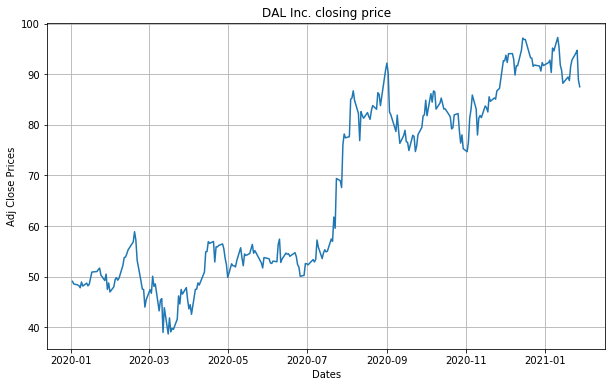

In [65]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Adj Close Prices')
plt.plot(df['Adj Close'])

plt.title('DAL Inc. closing price')
plt.show()

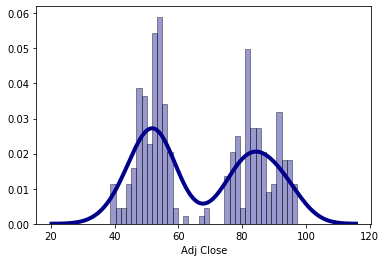

In [66]:
# Distribution of Adj Close
import seaborn as sns
sns.distplot(df['Adj Close'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [67]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
df_close = df['Adj Close']

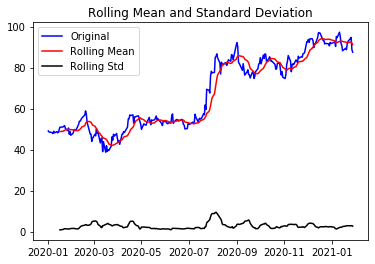

Results of Dickey-Fuller Test
Test Statistics                 -0.882851
p-value                          0.793567
No. of lags used                 1.000000
Number of observations used    269.000000
critical value (1%)             -3.454896
critical value (5%)             -2.872345
critical value (10%)            -2.572528
dtype: float64


In [68]:
# Check stationarity
# ADF Test
# Null Hyp: The series has unit root (alpha = 1)
# Alter Hyp: The series has no unit root

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of Dickey-Fuller Test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

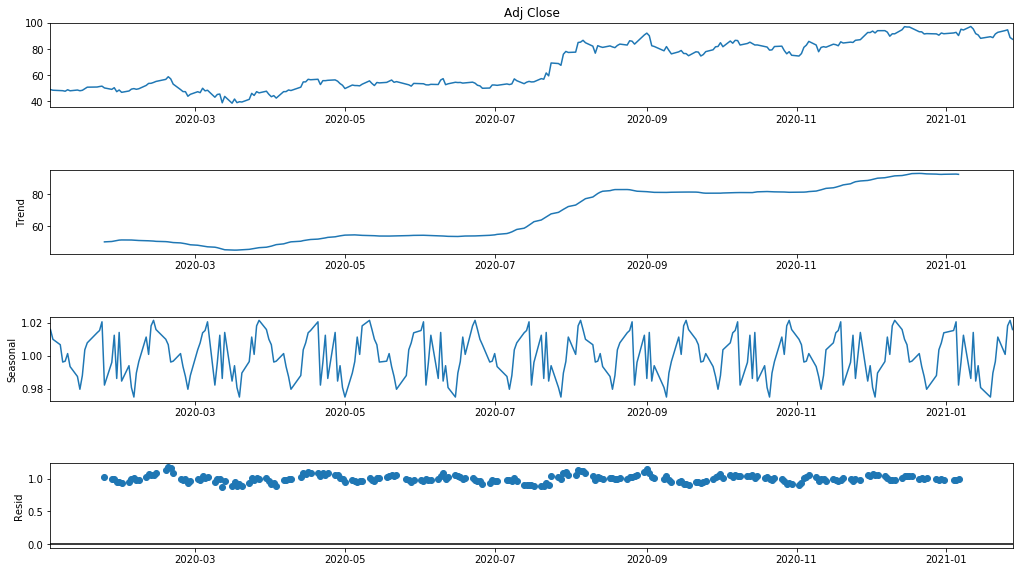

In [69]:
# Seperate Trends (Inceasing or decresing value) and Seasonality (Repeating short-term cycle)

result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


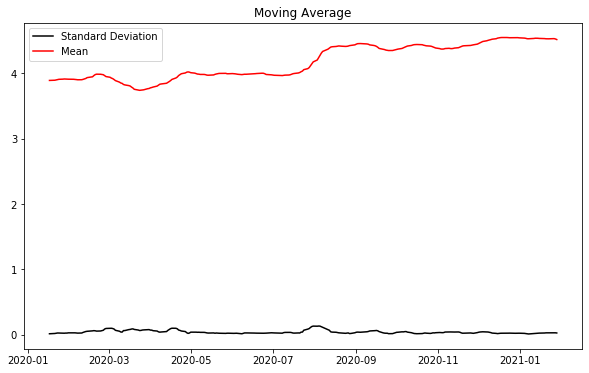

In [70]:
# Reduce Magnitude of values and rising trends in series by log
# Rolling average is calculated as past 12 months 

plt.figure(figsize=(10,6))
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [71]:
df_log
df_log[:int(len(df_log)*0.9)]

Date
2020-01-02    3.893859
2020-01-03    3.883623
2020-01-06    3.879293
2020-01-07    3.876396
2020-01-08    3.867653
                ...   
2020-12-10    4.518086
2020-12-11    4.517977
2020-12-14    4.551558
2020-12-15    4.575947
2020-12-16    4.573163
Name: Adj Close, Length: 243, dtype: float64

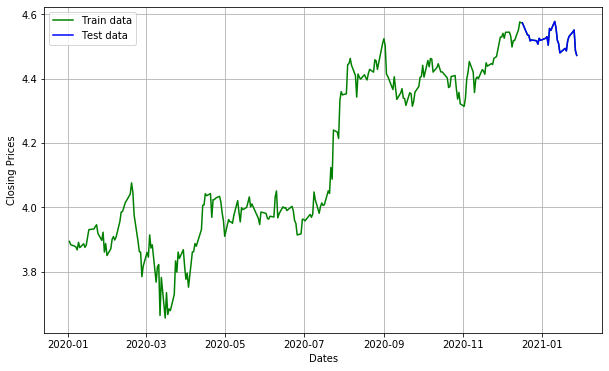

In [72]:
# Split Series into Train and Test
# Green as Train
# Blue as Test

train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

In [73]:
# use auto_arima to optimal choose p,q,d

from pmdarima import auto_arima

model_auto_ARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-882.527, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-894.254, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-891.447, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-883.260, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-894.646, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-893.205, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-892.960, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-893.796, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-891.183, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-894.979, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-894.207, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-893.693, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-893.590, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-893.915, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]          

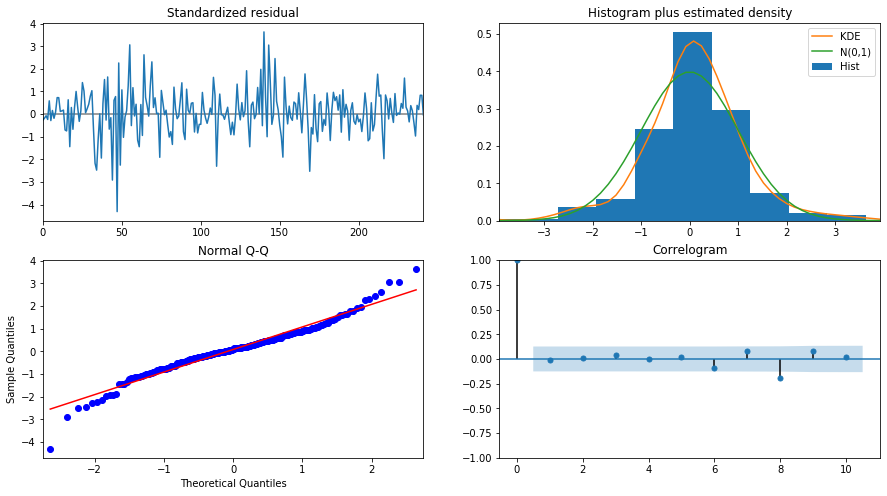

In [74]:
# The optimal p, d, q is under SARIMAX class.

model_auto_ARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [76]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  242
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 451.323
Method:                       css-mle   S.D. of innovations              0.037
Date:                Fri, 29 Jan 2021   AIC                           -894.646
Time:                        00:26:01   BIC                           -880.690
Sample:                             1   HQIC                          -889.024
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0028      0.002      1.302      0.193      -0.001       0.007
ar.L1.D.Adj Close    -0.2110      0.064     -3.307      0.001      -0.336      -0.086
ar.L2.D.Adj Close     0.

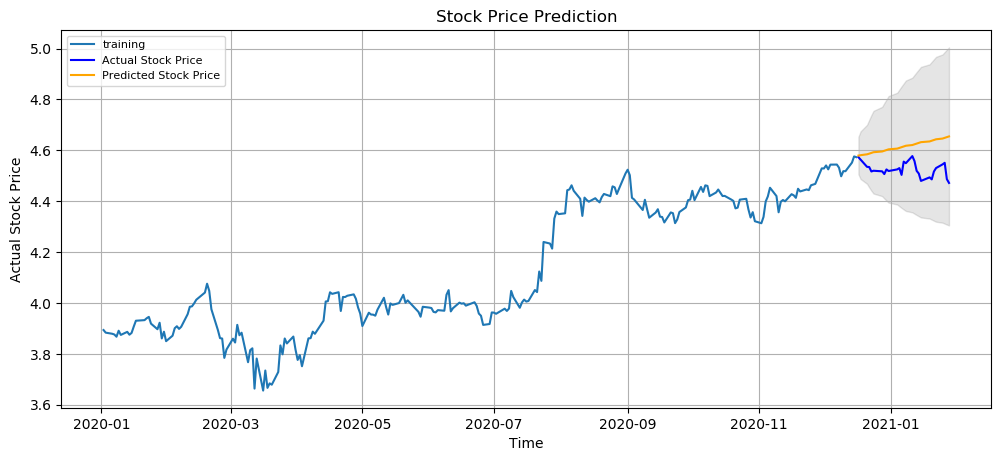

In [78]:
# Forecast
# Returns forecast samples, std of forecast, confidence interval

fc, se, conf = fitted.forecast(28, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.grid(True)
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()